# Hello Avid Readers!

# Objective
### 1). Find the sentiment around the titles of the books using AFINN model
        
### 2). Check how well we can predict the average rating using:
    a). Linear Regression    
    b). Random Forest    
### 3). Create Recommender System
    a). Recommends similar books (K-means)
    b). Recommends author based on a book (K-means)
    c). Recommends high rated books of the author (ALS)

In [156]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib 
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')

In [157]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round, desc,asc

In [158]:
spark = SparkSession.Builder().appName("BigDataProject").config('spark.sql.shuffle.partitions', '6').getOrCreate()
spark

# Preprocessing the Data

Removing missing data and lines with extra columns from dataset

In [159]:
# Importing the data to pandas to clean it
df_pd = pd.read_csv('gs://dataproc-staging-us-east1-1065697892836-1hwlipnw/notebooks/jupyter/books.csv',  error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [160]:
df_pd

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


In [161]:
# Setting the Index to Book Id and dropping that column

df_pd.index = df_pd['bookID']
df_pd = df_pd.drop(columns='bookID')

In [162]:
# Exporting this as a .csv file
#df_pd.to_csv('books_final.csv')

In [163]:
df = spark.read.csv("gs://dataproc-staging-us-east1-1065697892836-1hwlipnw/notebooks/jupyter/books_final.csv",header=True, inferSchema=True,).toDF('bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher')

In [164]:
df.show(5)
df.printSchema()

+------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+
|bookID|               title|             authors|average_rating|      isbn|       isbn13|language_code|num_pages|ratings_count|text_reviews_count|publication_date|      publisher|
+------+--------------------+--------------------+--------------+----------+-------------+-------------+---------+-------------+------------------+----------------+---------------+
|     1|Harry Potter and ...|J.K. Rowling/Mary...|          4.57|0439785960|9780439785969|          eng|      652|      2095690|             27591|       9/16/2006|Scholastic Inc.|
|     2|Harry Potter and ...|J.K. Rowling/Mary...|          4.49|0439358078|9780439358071|          eng|      870|      2153167|             29221|        9/1/2004|Scholastic Inc.|
|     4|Harry Potter and ...|        J.K. Rowling|          4.42|0439554896|9780439554893|     

# Exploratory Data Analysis & Visualization

## Language most of the books are written in

In [165]:
plot_df = df.groupBy("language_code").count().orderBy('count',ascending=False)
plot_df.show(10)

+-------------+-----+
|language_code|count|
+-------------+-----+
|          eng| 8908|
|        en-US| 1408|
|          spa|  218|
|        en-GB|  214|
|          fre|  144|
|          ger|   99|
|          jpn|   46|
|          mul|   19|
|          zho|   14|
|          grc|   11|
+-------------+-----+
only showing top 10 rows



In [166]:
plot_df = plot_df.toPandas()
plot_df = plot_df.loc[0:9]

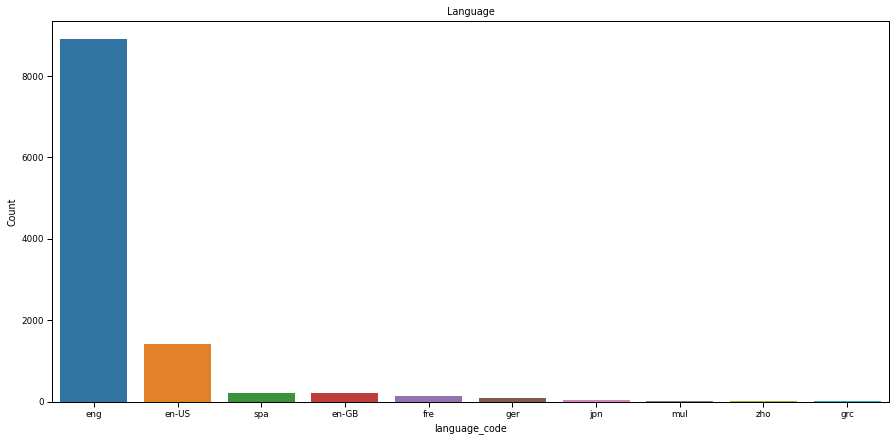

In [168]:
sns.set_context('paper')
plt.figure(figsize=(15,7))
sns.barplot(x = plot_df["language_code"].values , y = plot_df["count"].values)
plt.xlabel("language_code")
plt.ylabel("Count")
plt.title("Language")
plt.show()

**Inference**   
We can see that the language most of the books are written in is 'eng' English

## Top 10 Most Rated Books

In [169]:
df.select(df.title, df.ratings_count).orderBy('ratings_count',ascending=False).show(10)

+--------------------+-------------+
|               title|ratings_count|
+--------------------+-------------+
|Twilight (Twiligh...|      4597666|
|The Hobbit  or Th...|      2530894|
|The Catcher in th...|      2457092|
|Angels & Demons (...|      2418736|
|Harry Potter and ...|      2339585|
|Harry Potter and ...|      2293963|
|Harry Potter and ...|      2153167|
|The Fellowship of...|      2128944|
|         Animal Farm|      2111750|
|Harry Potter and ...|      2095690|
+--------------------+-------------+
only showing top 10 rows



Text(0, 0.5, 'Title')

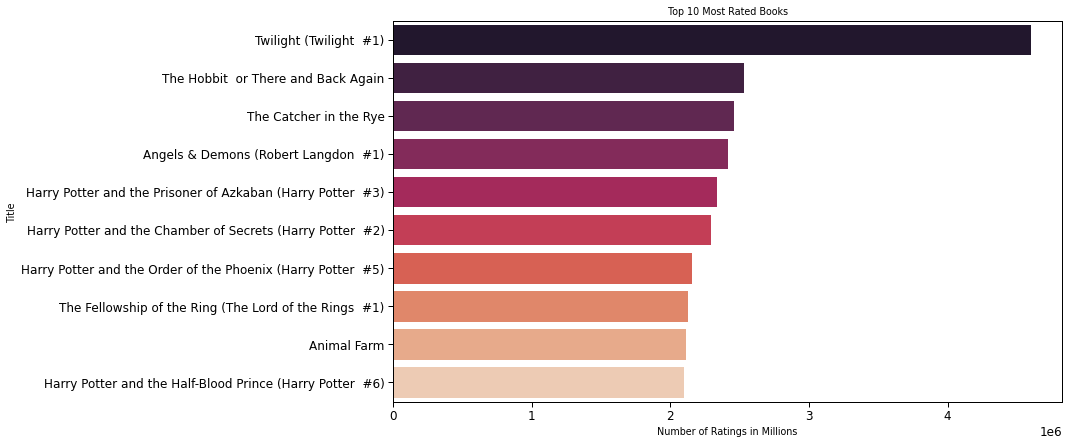

In [170]:
most_rated = df.toPandas().sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(12,7))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='rocket')
plt.title("Top 10 Most Rated Books")
plt.xlabel("Number of Ratings in Millions")
plt.ylabel("Title")

**Inference**  
Twilight is the most rated book with around 4.6 million ratings followed by The Hobbit with about 2.5 million ratings

## Authors with the Most Published Books

In [171]:
df.groupBy("authors").count().withColumnRenamed("count", "No. of Books").sort(desc("count")).show(10)

+----------------+------------+
|         authors|No. of Books|
+----------------+------------+
|  P.G. Wodehouse|          40|
|    Stephen King|          40|
|Rumiko Takahashi|          39|
|Orson Scott Card|          35|
| Agatha Christie|          33|
|   Piers Anthony|          30|
| Mercedes Lackey|          29|
|    Sandra Brown|          29|
|    Dick Francis|          28|
| James Patterson|          23|
+----------------+------------+
only showing top 10 rows



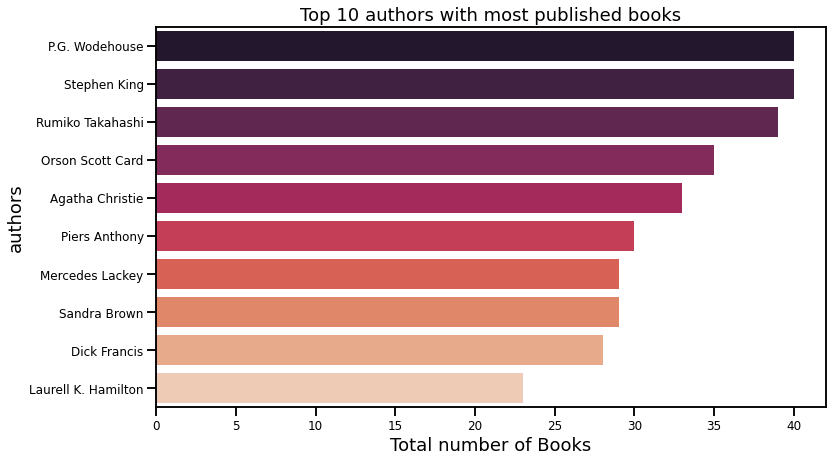

In [172]:
# Authors with most books

sns.set_context('talk')
most_books = df.toPandas().groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(12,7))
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
ax = sns.barplot(most_books['title'], most_books.index, palette='rocket')
ax.set_title("Top 10 authors with most published books")
ax.set_xlabel("Total number of Books")
plt.show()

**Inference**  
P.G. Wodehouse and Stephen King have written the most books (40) followed by Rumiko Takahashi (39)

## Highest Rated Books and their Authors'

In [34]:
# All books with an average rating greater than or equal to 4.3

df.select("title","authors","average_rating").orderBy('average_rating',ascending=False).filter(df.average_rating >= 4.3).show(20)

+--------------------+--------------------+--------------+
|               title|             authors|average_rating|
+--------------------+--------------------+--------------+
|Bulgakov's the Ma...|     Elena N. Mahlow|           5.0|
|Comoediae 1: Acha...|Aristophanes/F.W....|           5.0|
|Willem de Kooning...|Julie Sylvester/D...|           5.0|
|Literature Circle...|      Tara MacCarthy|           5.0|
|Middlesex Borough...|Middlesex Borough...|           5.0|
|Zone of the Ender...|          Tim Bogenn|           5.0|
|The Diamond Color...|       John  Diamond|           5.0|
|The Complete Theo...|Ian        Martin...|           5.0|
|The Goon Show  Vo...|          NOT A BOOK|           5.0|
|The Goon Show  Vo...|          NOT A BOOK|           5.0|
| Winchester Shotguns|Dennis Adler/R.L....|           5.0|
|Colossians and Ph...|      R. McL. Wilson|           5.0|
|Taxation of Miner...|        Ross Garnaut|           5.0|
|The New Big Book ...|Todd Davis/Marc Frey|           5.

In [173]:
# Number of books of authors who's books have a rating greater than or equal to 4.3

df.filter(df.average_rating >= 4.3).groupBy("authors").count().orderBy('count',ascending=False).show(20)

+----------------------+-----+
|               authors|count|
+----------------------+-----+
|        J.R.R. Tolkien|   12|
|  Hiromu Arakawa/Ak...|   12|
|          J.K. Rowling|   11|
|             Tite Kubo|   10|
|       Patrick O'Brian|    8|
|Hiromu Arakawa/荒川...|    8|
|  Hirohiko Araki/Hi...|    7|
|       Karen Kingsbury|    7|
|        P.G. Wodehouse|    7|
|        Bill Watterson|    7|
|        Hirohiko Araki|    6|
|  J.K. Rowling/Mary...|    6|
|        Diana Gabaldon|    5|
|        Hiromu Arakawa|    5|
|          Stephen King|    5|
|         Thomas Sowell|    5|
|  Karen Kingsbury/G...|    5|
|         Douglas Adams|    5|
|      Shel Silverstein|    5|
|         James Baldwin|    4|
+----------------------+-----+
only showing top 20 rows



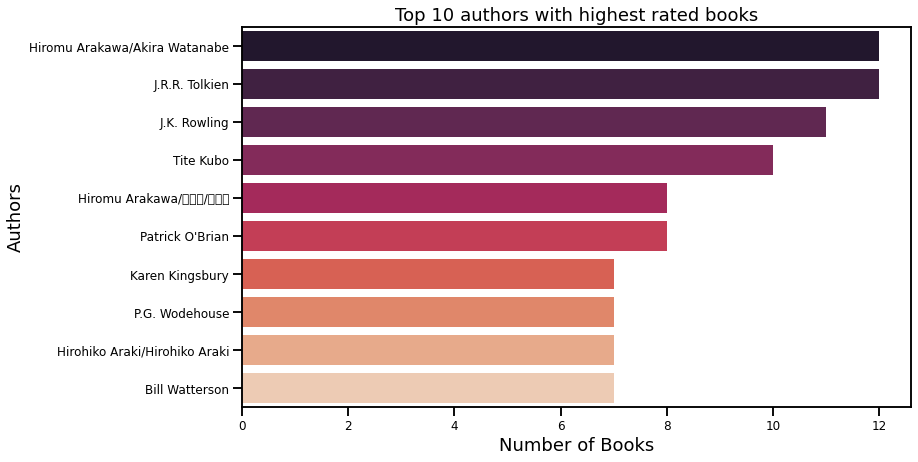

In [128]:
high_rated_author = df.toPandas()[df.toPandas()['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(12,7))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='rocket')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
ax.set_title("Top 10 authors with highest rated books")
plt.show()

**Inference**   
We can see, Hiromu Arakawa and J.R.R Tolkien have the most number of books (12) that are rated greater than 4.3

## Top 10 Authors with highest average # of pages per book

In [174]:
def plot_authors(data, y, title):
    plt.figure(figsize=(12,10))
    sns.barplot(x=data["authors"].str.split("/",n=-1, expand = True)[0],
            y =  data[y], data = data, palette="rocket")
    plt.title(title)
    plt.ylabel(y)
    plt.xlabel("authors")
    plt.xticks(rotation = 30)
    plt.show()

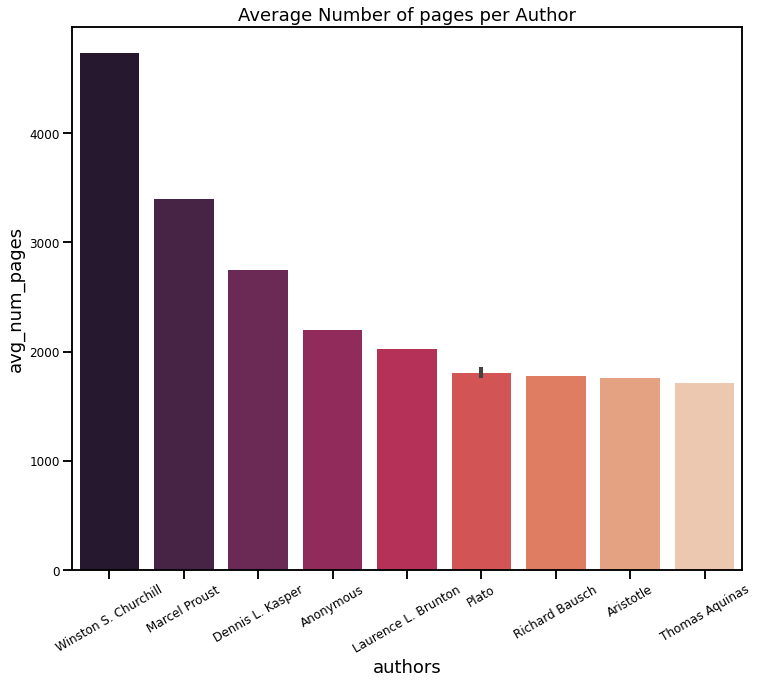

In [175]:
plotdf = df["authors",'num_pages'].groupBy("authors").avg().\
select("authors",round(col("avg(num_pages)"),2).alias("avg_num_pages")).\
orderBy(desc("avg_num_pages")).toPandas().loc[0:9]

plot_authors(plotdf,"avg_num_pages", "Average Number of pages per Author")

**Inference**  
Winston Churchill on an average wrote more in his books than the rest of the authors

## Top 10 Authors with highest average rating count

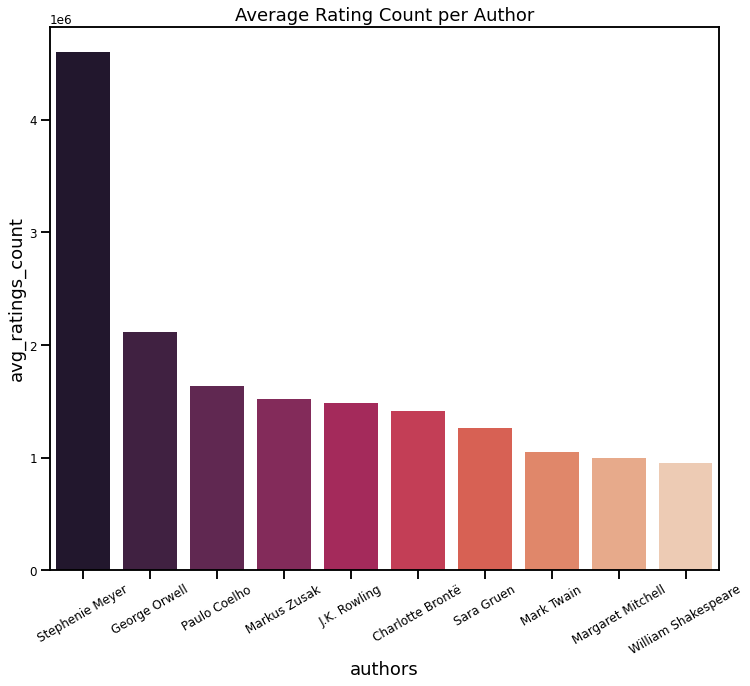

In [176]:
plotdf = df["authors",'ratings_count'].groupBy("authors").avg().\
select("authors",round(col("avg(ratings_count)"),2).alias("avg_ratings_count")).\
orderBy(desc("avg_ratings_count")).toPandas().loc[0:9]

plot_authors(plotdf,"avg_ratings_count", "Average Rating Count per Author")

**Inference**  
Stephenie Meyer’s books have been reviewed the most

## Top 10 Authors with highest average # of text review count

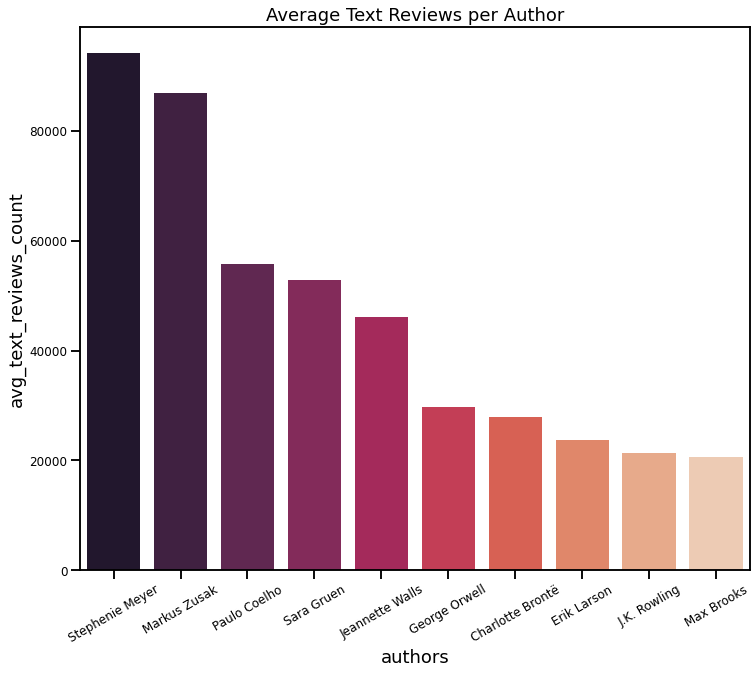

In [177]:
plotdf = df["authors",'text_reviews_count'].groupBy("authors").avg().\
select("authors",round(col("avg(text_reviews_count)"),2).alias("avg_text_reviews_count")).\
orderBy(desc("avg_text_reviews_count")).toPandas().loc[0:9]

plot_authors(plotdf,"avg_text_reviews_count", "Average Text Reviews per Author")

**Inference**  
Stephenie Meyer’s books received more text reviews followed by Markus Zusak

## Activity of Author

In [178]:
def author_activity(author):
    years = df.filter(df.authors == author).select(['publication_date']).toPandas()
    years["publication_date"] = pd.DatetimeIndex(years['publication_date']).year
    years = pd.DataFrame(sorted(years["publication_date"]))
    years = years.rename(columns={0: "year"})
    temp = years.value_counts()
    counts = years.value_counts().tolist()
    index = temp.index
    x = []
    for i in index:
        x.append(i[0])
    sns.set_context('poster')
    plt.figure(figsize=(12,10))
    matplotlib.rc('xtick', labelsize=12) 
    matplotlib.rc('ytick', labelsize=12) 
    sns.barplot(x = x , y = counts, palette='rocket')
    plt.title("Author Activity: "+author)
    plt.xlabel("Years")
    plt.ylabel("Books")
    plt.show()

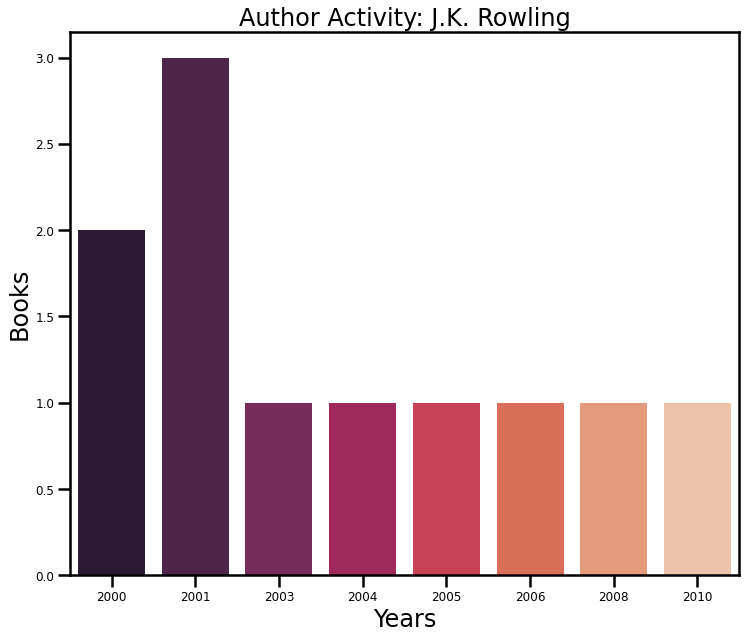

In [179]:
author_activity('J.K. Rowling')

**Inference**   
Between 2003-2006 J.K. Rowling have atleast published one book each year.

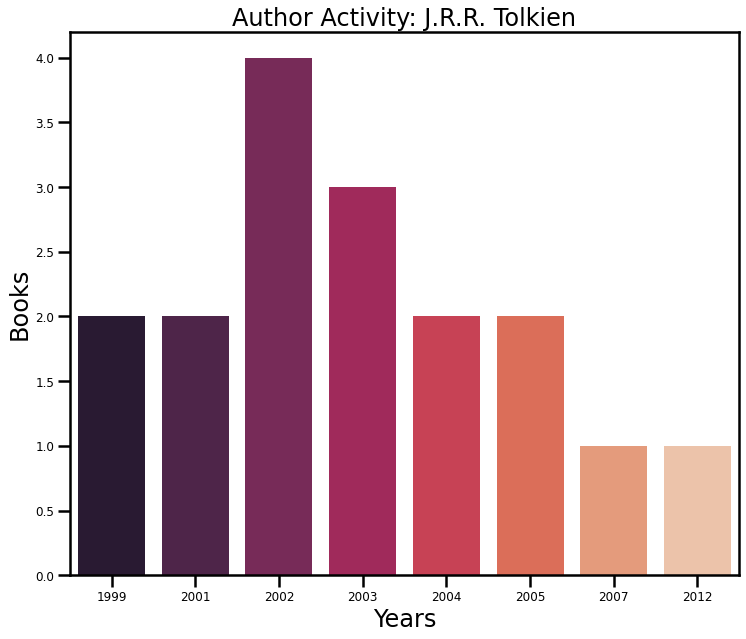

In [180]:
author_activity('J.R.R. Tolkien')

**Inference**   
J.R.R. Tolkien published more books in 2002 (4)

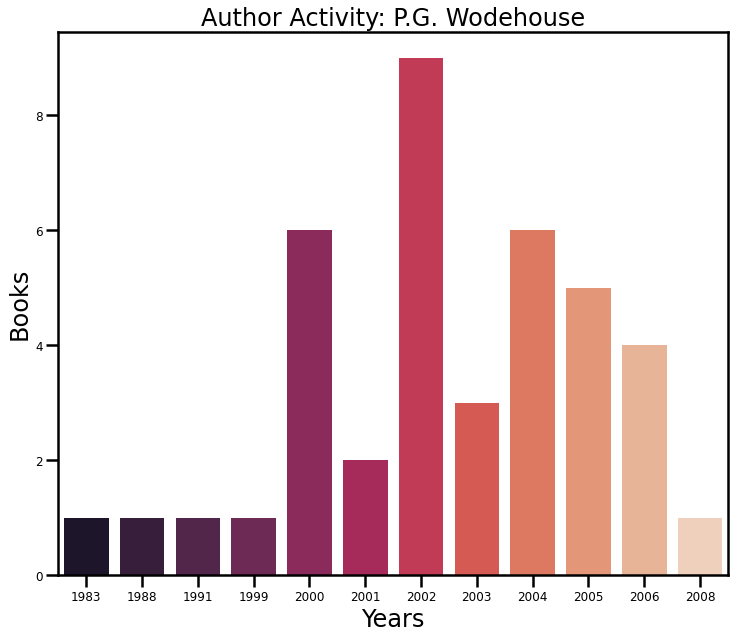

In [181]:
author_activity('P.G. Wodehouse')

**Inference**   
P.G. Wodehouse wrote more books in 2000s as compared to previous decades.

## Correlation heatmap for Average Rating

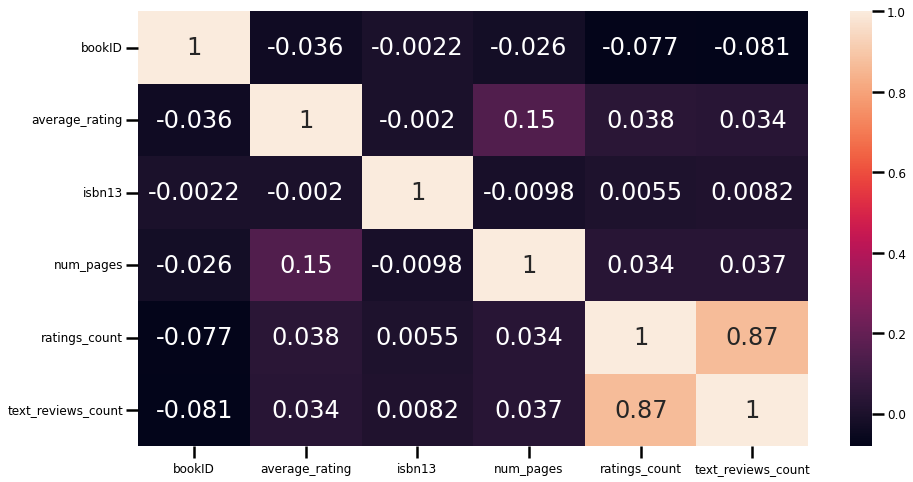

In [182]:
plt.figure(figsize = (15,8))
sns.heatmap(df.toPandas().corr(),annot=True)
plt.show()

<AxesSubplot:title={'center':'Correlation with average_rating'}>

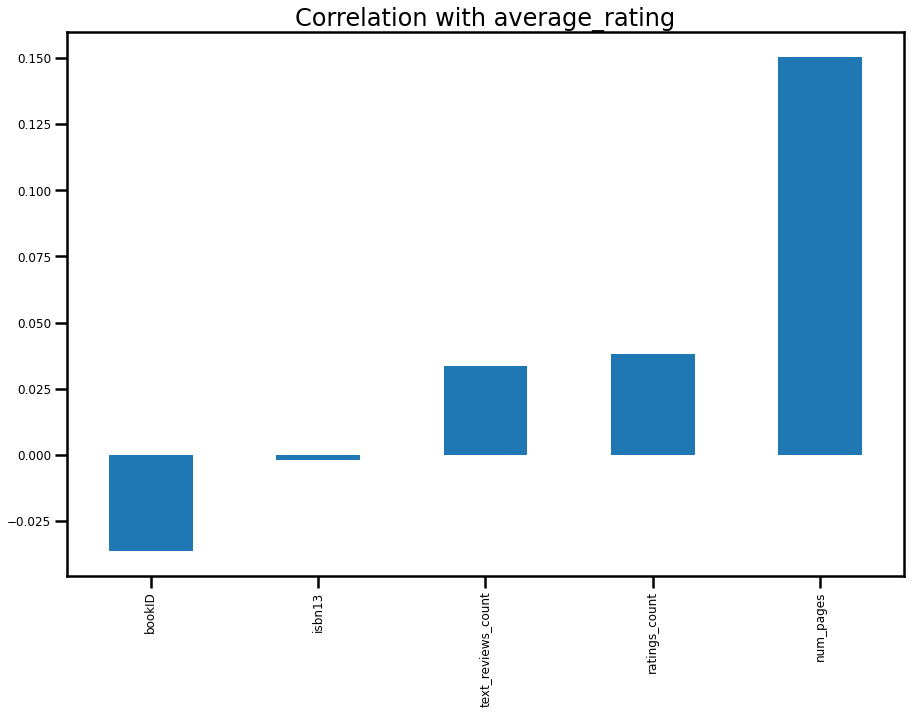

In [183]:
df.toPandas().corr()['average_rating'].sort_values()[:-1:].plot(kind='bar', figsize=(15,10), 
                                                        title= "Correlation with average_rating")

**Inference**   
From the heatmap and the barplot above, we can see that the numeric **features** are **not highly correlated to 'average_rating'**. Later, in our regression models we will see how these columns performs when used to predict the 'average_rating'

## Relationship between Average ratings and # of pages

<Figure size 1368x720 with 0 Axes>

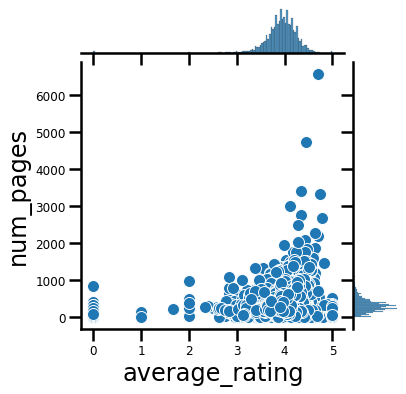

In [154]:
plt.figure(figsize=(19,10))
sns.jointplot(x = 'average_rating', y = 'num_pages', data = df.toPandas(), kind = 'scatter')
plt.show()

## Relationship between Average ratings and Text reviews

<Figure size 1368x720 with 0 Axes>

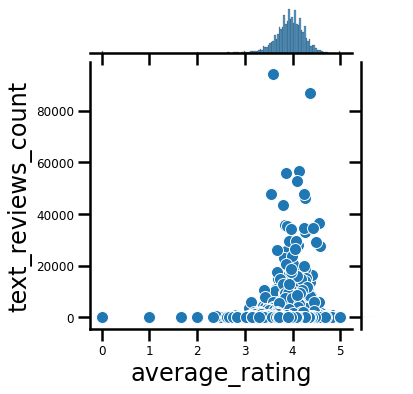

In [48]:
plt.figure(figsize=(19,10))
sns.jointplot(x = 'average_rating', y = 'text_reviews_count', data = df.toPandas(), kind = 'scatter')
plt.show()

**Inference**   
From the above two jointplots, we can see that the data is **normally distributed** wrt to both **number of pages and total number of text reviews**, with most of the books being rated between 3-5 stars.

# Sentiment analysis using AFINN model on titles

In [184]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, StopWordsRemover

In [185]:
df_title = df.select('bookID','title')
df_title.show(5)

+------+--------------------+
|bookID|               title|
+------+--------------------+
|     1|Harry Potter and ...|
|     2|Harry Potter and ...|
|     4|Harry Potter and ...|
|     5|Harry Potter and ...|
|     8|Harry Potter Boxe...|
+------+--------------------+
only showing top 5 rows



In [186]:
tokenizer = Tokenizer(inputCol="title", 
                      outputCol="words")

wordsData = tokenizer.transform(df_title)
wordsData.show(5, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------
 bookID | 1                                                                         
 title  | Harry Potter and the Half-Blood Prince (Harry Potter  #6)                 
 words  | [harry, potter, and, the, half-blood, prince, (harry, potter, , #6)]      
-RECORD 1---------------------------------------------------------------------------
 bookID | 2                                                                         
 title  | Harry Potter and the Order of the Phoenix (Harry Potter  #5)              
 words  | [harry, potter, and, the, order, of, the, phoenix, (harry, potter, , #5)] 
-RECORD 2---------------------------------------------------------------------------
 bookID | 4                                                                         
 title  | Harry Potter and the Chamber of Secrets (Harry Potter  #2)                
 words  | [harry, potter, and, the, chamber, of, secrets, (harry,

In [187]:
tokenizer = RegexTokenizer(inputCol="title",
                           outputCol="words", 
                           pattern= "\\W")

wordsData = tokenizer.transform(df_title)
wordsData.show(5, truncate=False, vertical=True)


-RECORD 0----------------------------------------------------------------------
 bookID | 1                                                                    
 title  | Harry Potter and the Half-Blood Prince (Harry Potter  #6)            
 words  | [harry, potter, and, the, half, blood, prince, harry, potter, 6]     
-RECORD 1----------------------------------------------------------------------
 bookID | 2                                                                    
 title  | Harry Potter and the Order of the Phoenix (Harry Potter  #5)         
 words  | [harry, potter, and, the, order, of, the, phoenix, harry, potter, 5] 
-RECORD 2----------------------------------------------------------------------
 bookID | 4                                                                    
 title  | Harry Potter and the Chamber of Secrets (Harry Potter  #2)           
 words  | [harry, potter, and, the, chamber, of, secrets, harry, potter, 2]    
-RECORD 3-------------------------------

In [188]:
remover = StopWordsRemover(inputCol="words", 
                           outputCol="filteredWords")

In [189]:
noStopWordsDF = remover.transform(wordsData)

noStopWordsDF.show(5, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------
 bookID        | 1                                                                    
 title         | Harry Potter and the Half-Blood Prince (Harry Potter  #6)            
 words         | [harry, potter, and, the, half, blood, prince, harry, potter, 6]     
 filteredWords | [harry, potter, half, blood, prince, harry, potter, 6]               
-RECORD 1-----------------------------------------------------------------------------
 bookID        | 2                                                                    
 title         | Harry Potter and the Order of the Phoenix (Harry Potter  #5)         
 words         | [harry, potter, and, the, order, of, the, phoenix, harry, potter, 5] 
 filteredWords | [harry, potter, order, phoenix, harry, potter, 5]                    
-RECORD 2-----------------------------------------------------------------------------
 bookID        | 4                         

In [190]:
noStopWordsDF.show()

+------+--------------------+--------------------+--------------------+
|bookID|               title|               words|       filteredWords|
+------+--------------------+--------------------+--------------------+
|     1|Harry Potter and ...|[harry, potter, a...|[harry, potter, h...|
|     2|Harry Potter and ...|[harry, potter, a...|[harry, potter, o...|
|     4|Harry Potter and ...|[harry, potter, a...|[harry, potter, c...|
|     5|Harry Potter and ...|[harry, potter, a...|[harry, potter, p...|
|     8|Harry Potter Boxe...|[harry, potter, b...|[harry, potter, b...|
|     9|"Unauthorized Har...|[unauthorized, ha...|[unauthorized, ha...|
|    10|Harry Potter Coll...|[harry, potter, c...|[harry, potter, c...|
|    12|The Ultimate Hitc...|[the, ultimate, h...|[ultimate, hitchh...|
|    13|The Ultimate Hitc...|[the, ultimate, h...|[ultimate, hitchh...|
|    14|The Hitchhiker's ...|[the, hitchhiker,...|[hitchhiker, guid...|
|    16|The Hitchhiker's ...|[the, hitchhiker,...|[hitchhiker, g

In [191]:
noStopWordsDF_pd = noStopWordsDF.toPandas()

In [192]:
noStopWordsDF_pd.head(5)

,bookID,title,words,filteredWords
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[harry, potter, and, the, half, blood, prince,...","[harry, potter, half, blood, prince, harry, po..."
1,2,Harry Potter and the Order of the Phoenix (Har...,"[harry, potter, and, the, order, of, the, phoe...","[harry, potter, order, phoenix, harry, potter, 5]"
2,4,Harry Potter and the Chamber of Secrets (Harry...,"[harry, potter, and, the, chamber, of, secrets...","[harry, potter, chamber, secrets, harry, potte..."
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[harry, potter, and, the, prisoner, of, azkaba...","[harry, potter, prisoner, azkaban, harry, pott..."
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[harry, potter, boxed, set, books, 1, 5, harry...","[harry, potter, boxed, set, books, 1, 5, harry..."


In [193]:
filteredSentences = []
for row in noStopWordsDF_pd['filteredWords']:
    s = ' '.join(row)
    filteredSentences.append(s)
    
noStopWordsDF_pd['filteredSentences'] = filteredSentences  
noStopWordsDF_pd['filteredSentences'] = noStopWordsDF_pd['filteredSentences'].apply(lambda x: re.sub(r'[0-9]+', '', x)) 
noStopWordsDF_pd.head(5)

,bookID,title,words,filteredWords,filteredSentences
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[harry, potter, and, the, half, blood, prince,...","[harry, potter, half, blood, prince, harry, po...",harry potter half blood prince harry potter
1,2,Harry Potter and the Order of the Phoenix (Har...,"[harry, potter, and, the, order, of, the, phoe...","[harry, potter, order, phoenix, harry, potter, 5]",harry potter order phoenix harry potter
2,4,Harry Potter and the Chamber of Secrets (Harry...,"[harry, potter, and, the, chamber, of, secrets...","[harry, potter, chamber, secrets, harry, potte...",harry potter chamber secrets harry potter
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[harry, potter, and, the, prisoner, of, azkaba...","[harry, potter, prisoner, azkaban, harry, pott...",harry potter prisoner azkaban harry potter
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[harry, potter, boxed, set, books, 1, 5, harry...","[harry, potter, boxed, set, books, 1, 5, harry...",harry potter boxed set books harry potter


In [194]:
from afinn import Afinn

afn = Afinn()

scores = [afn.score(article) for article in noStopWordsDF_pd['filteredSentences']]
sentiment = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' for score in scores]

noStopWordsDF_pd['sentiment_scores'] = scores
noStopWordsDF_pd['affin_sentiments'] = sentiment
noStopWordsDF_pd.head(5)

,bookID,title,words,filteredWords,filteredSentences,sentiment_scores,affin_sentiments
0,1,Harry Potter and the Half-Blood Prince (Harry ...,"[harry, potter, and, the, half, blood, prince,...","[harry, potter, half, blood, prince, harry, po...",harry potter half blood prince harry potter,0.0,neutral
1,2,Harry Potter and the Order of the Phoenix (Har...,"[harry, potter, and, the, order, of, the, phoe...","[harry, potter, order, phoenix, harry, potter, 5]",harry potter order phoenix harry potter,0.0,neutral
2,4,Harry Potter and the Chamber of Secrets (Harry...,"[harry, potter, and, the, chamber, of, secrets...","[harry, potter, chamber, secrets, harry, potte...",harry potter chamber secrets harry potter,0.0,neutral
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,"[harry, potter, and, the, prisoner, of, azkaba...","[harry, potter, prisoner, azkaban, harry, pott...",harry potter prisoner azkaban harry potter,-2.0,negative
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,"[harry, potter, boxed, set, books, 1, 5, harry...","[harry, potter, boxed, set, books, 1, 5, harry...",harry potter boxed set books harry potter,0.0,neutral


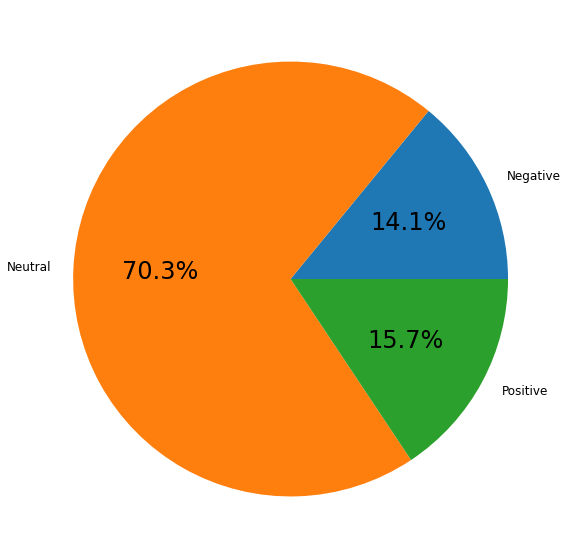

In [195]:
negative_count = noStopWordsDF_pd[noStopWordsDF_pd['sentiment_scores'] < 0]
neutral_count = noStopWordsDF_pd[noStopWordsDF_pd['sentiment_scores'] == 0]
positive_count = noStopWordsDF_pd[noStopWordsDF_pd['sentiment_scores'] > 0]

title_type = ['Negative','Neutral', 'Positive']
data = [len(negative_count),len(neutral_count),len(positive_count)]

plt.figure(figsize=(15,10))
plt.pie(data, labels = title_type, autopct = '%1.1f%%')
plt.show()

# Predicting Average Rating Using Regression Methods

## Common Class for all the Models

Takes the train and test data, builds the model, evaluates and predicts the results. Also, returns the prediction and evaluator for futher analysis

In [197]:
from pyspark.ml.evaluation import RegressionEvaluator

class Model:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        
    def lin_reg(self, label):
        model = LinearRegression(labelCol=label).fit(self.train_data)
        return model
    
    def kmeans(self, features, num_k):
        model = KMeans(featuresCol=features,k=num_k).fit(self.train_data)
        return model
    
    def rforest(self, label, features):
        model = RandomForestRegressor(featuresCol=features, labelCol=label).fit(self.train_data)
        return model
    
    def als(self, mi, user, item, rate):
        model = ALS(maxIter=mi, regParam=0.01, 
                    userCol=user, itemCol=item, ratingCol=rate).fit(self.train_data)
        return model

    def evaluate(self, model):

        test_results = model.evaluate(self.test_data)
        return test_results
        
    def predict(self, model, metric, label, pred):
        predictions = model.transform(self.test_data)
        
        try:
            evaluator = RegressionEvaluator(metricName=metric, labelCol=label,predictionCol=pred)
            
        except:
            predictions = model.transform(self.test_data)
            evaluator= None
        
        return predictions, evaluator 

## Train/Test Splits
Randomly splits the data into 70-30 train-test split

In [198]:
def split(final_data):
    train_data,test_data = final_data.randomSplit([0.7,0.3], seed= 5364)
    print("{} rows in the train_data".format(train_data.count()))
    print("{} rows in the test_data".format(test_data.count()))
    
    return train_data, test_data

# Prepocessing 

## Creates Vector Assembler


In [199]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

def create_assembler(dataset, input_cols):
    
    assembler = VectorAssembler(
    inputCols=input_cols,
    outputCol="features")
    output = assembler.transform(dataset)
    
    return output

## Returns complete title of the book¶

In [200]:
def clean_title(title):
    book_list = list((df.select(["title"]).toPandas())["title"])
    for name in book_list:
            if title in name:
                cleaned_tile = name
    return cleaned_tile

## Linear Regression

In [201]:
from pyspark.ml.regression import LinearRegression

# a). Creates the instance of the "Model" class
# b). Builds the linear regression model by calling "lin_reg" function from the class "Model" 
# c). Calls the "evaluate" and "predict" functions from the class "Model" 
# d). Returns the prediction and the model for futher analysis

def main(train_data, test_data):
    lr = Model(train_data, test_data)
    model = lr.lin_reg(label="average_rating")
     # Print the coefficients and intercept for linear regression
    print("Coefficients: {} Intercept: {}\n".format(model.coefficients,model.intercept))
    
    results = lr.evaluate(model)
    print("RMSE: {}".format(results.rootMeanSquaredError))
    print("MSE: {}".format(results.meanSquaredError))
    print("R2: {}\n".format(results.r2))
    
    predictions, evaluator = lr.predict(model, pred=None, label=None, metric=None)
    return predictions, model

In [202]:
input_cols = ['num_pages','ratings_count','text_reviews_count']
output = create_assembler(df, input_cols) # Function call to create vector assembler
final_data = output.select("features", "bookID", "average_rating")
final_data.show()

+--------------------+------+--------------+
|            features|bookID|average_rating|
+--------------------+------+--------------+
|[652.0,2095690.0,...|     1|          4.57|
|[870.0,2153167.0,...|     2|          4.49|
|[352.0,6333.0,244.0]|     4|          4.42|
|[435.0,2339585.0,...|     5|          4.56|
|[2690.0,41428.0,1...|     8|          4.78|
|    [152.0,19.0,1.0]|     9|          3.74|
|[3342.0,28242.0,8...|    10|          4.73|
|[815.0,3628.0,254.0]|    12|          4.38|
|[815.0,249558.0,4...|    13|          4.38|
|[215.0,4930.0,460.0]|    14|          4.22|
|  [6.0,1266.0,253.0]|    16|          4.22|
|[815.0,2877.0,195.0]|    18|          4.38|
|[544.0,248558.0,9...|    21|          4.21|
| [55.0,7270.0,499.0]|    22|          3.44|
|[256.0,2088.0,131.0]|    23|          3.87|
|[335.0,72451.0,42...|    24|          4.07|
|[304.0,49240.0,22...|    25|           3.9|
|[299.0,45712.0,22...|    26|          3.83|
|[254.0,48701.0,22...|    27|          3.86|
|[324.0,80

In [203]:
final_data.count()

11123

In [204]:
# Removes 3 bookID from the main dataset to be used to predict on new data later
final_data = final_data.filter(~final_data.bookID.isin(["15245","313","45639"]))
final_data.count()

11120

In [205]:
# Train and Test Dataset
train_data, test_data = split(final_data) # Function call to split the data into train-test sets
lin_pred, lin_model = main(train_data, test_data) # Function call for the main linear regression model
lin_pred.join(df.select("title","bookID"), on="bookID").show()

7792 rows in the train_data
3328 rows in the test_data


22/05/02 00:04:38 WARN org.apache.spark.ml.util.Instrumentation: [58c54968] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [0.00021330761278788633,9.860280024036878e-08,-2.66874228659697e-07] Intercept: 3.8626131591106097

RMSE: 0.3700004143702318
MSE: 0.13690030663414324
R2: 0.02085417305349868

+------+--------------------+--------------+------------------+--------------------+
|bookID|            features|average_rating|        prediction|               title|
+------+--------------------+--------------+------------------+--------------------+
|    12|[815.0,3628.0,254.0]|          4.38| 4.036748808437929|The Ultimate Hitc...|
|    13|[815.0,249558.0,4...|          4.38|4.0599771343021915|The Ultimate Hitc...|
|    18|[815.0,2877.0,195.0]|          4.38|  4.03669050331444|The Ultimate Hitc...|
|    23|[256.0,2088.0,131.0]|          3.87| 3.917390830107256|Bryson's Dictiona...|
|    25|[304.0,49240.0,22...|           3.9| 3.931723816362396|I'm a Stranger He...|
|    28|[324.0,80609.0,33...|          3.91| 3.938792146949655|Notes from a Smal...|
|    29|[270.0,28489.0,20...|          3.93| 3

## Predicting on new values

In [206]:
def predict_single(title, model):
    
    title = clean_title(title)
    
    s1 = df.filter(df['title']==title).distinct()
    input_cols = ['num_pages','ratings_count','text_reviews_count']
    output = create_assembler(s1, input_cols)
    single_data = output.select("features", "bookID", "average_rating")
    
    new_rating = model.transform(single_data)
    print(f"Prediction for - {title} \n")
    new_rating.join(df.select(["title","bookID"]), on="bookID").\
        orderBy('prediction',ascending=False).show(1)

In [207]:
title = "The Lord of the Rings"
predict_single(title, lin_model) # Function call

Prediction for - The Return of the King (The Lord of the Rings  #3) 

+------+-----------------+--------------+------------------+--------------------+
|bookID|         features|average_rating|        prediction|               title|
+------+-----------------+--------------+------------------+--------------------+
| 15245|[554.0,265.0,5.0]|          4.53|3.9808103719660193|The Return of the...|
+------+-----------------+--------------+------------------+--------------------+
only showing top 1 row



In [208]:
title = "100 Years of Lynchings"
predict_single(title, lin_model) # Function call

Prediction for - 100 Years of Lynchings 

+------+----------------+--------------+------------------+--------------------+
|bookID|        features|average_rating|        prediction|               title|
+------+----------------+--------------+------------------+--------------------+
|   313|[270.0,88.0,4.0]|          4.61|3.9202138241128455|100 Years of Lync...|
+------+----------------+--------------+------------------+--------------------+



In [209]:
title = "Poor People"
predict_single(title, lin_model) # Function call

Prediction for - Poor People 

+------+-------------------+--------------+------------------+-----------+
|bookID|           features|average_rating|        prediction|      title|
+------+-------------------+--------------+------------------+-----------+
| 45639|[434.0,769.0,139.0]|          3.72|3.9552273930961537|Poor People|
+------+-------------------+--------------+------------------+-----------+



## Random Forest

In [210]:
from pyspark.ml.regression import RandomForestRegressor

# a). Creates the instance of the "Model" class
# b). Builds the Random forest regressor model by calling "rforest" function from the class "Model" 
# c). Calls the "predict" function from the class "Model" 
# d). Returns the prediction and the model for futher analysis

def rforest_main(train_data, test_data):
    rfc = Model(train_data, test_data)
    model = rfc.rforest(label="average_rating", features="features")
    
    predictions, evaluator = rfc.predict(model, "rmse", 
                                           "average_rating","prediction")

    rmse = evaluator.evaluate(predictions)

    print('-'*80)
    print("Root-mean-square error = " + str(rmse))
    
    return predictions, model

In [211]:
#### Train-Test Dataset
rf_pred, rf_model = rforest_main(train_data, test_data) # Function call for the main Random forest model
rf_pred = rf_pred.join(df.select("title","bookID"), on="bookID")

--------------------------------------------------------------------------------
Root-mean-square error = 0.36008332903746576


## Predicting on new values

In [212]:
title = "The Lord of the Rings"
predict_single(title, rf_model) # Function call

Prediction for - The Return of the King (The Lord of the Rings  #3) 

+------+-----------------+--------------+-----------------+--------------------+
|bookID|         features|average_rating|       prediction|               title|
+------+-----------------+--------------+-----------------+--------------------+
| 15245|[554.0,265.0,5.0]|          4.53|4.023863791659892|The Return of the...|
+------+-----------------+--------------+-----------------+--------------------+
only showing top 1 row



In [213]:
title = "100 Years of Lynchings"
predict_single(title, rf_model) # Function call

Prediction for - 100 Years of Lynchings 

+------+----------------+--------------+-----------------+--------------------+
|bookID|        features|average_rating|       prediction|               title|
+------+----------------+--------------+-----------------+--------------------+
|   313|[270.0,88.0,4.0]|          4.61|3.911140128531428|100 Years of Lync...|
+------+----------------+--------------+-----------------+--------------------+



In [214]:
title = "Poor People"
predict_single(title, rf_model) # Function call

Prediction for - Poor People 

+------+-------------------+--------------+-----------------+-----------+
|bookID|           features|average_rating|       prediction|      title|
+------+-------------------+--------------+-----------------+-----------+
| 45639|[434.0,769.0,139.0]|          3.72|3.932322760306063|Poor People|
+------+-------------------+--------------+-----------------+-----------+



# Preprocessing for Recommender System

## Data Scaling

In [215]:
from pyspark.ml.feature import StandardScaler
def scaling(final_data):
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

    scalerModel = scaler.fit(final_data.select("features"))
    scaled_data = scalerModel.transform(final_data.select("features"))
    
    return scaled_data

# Book Recommender Systems

## K-Means

Recommends similar books based on average rating, # of reviews, # of pages per book

In [216]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [217]:
input_cols = ['average_rating','num_pages','ratings_count','text_reviews_count']
output = create_assembler(df, input_cols) # Function call to create the vector assembler
final_data = output.select("features", 'title')
final_data.show()

scaled_data = scaling(final_data) # Function call to scale the data(Standard scaler)
train_data, test_data = split(scaled_data) # Function call to split the data into train-test sets

+--------------------+--------------------+
|            features|               title|
+--------------------+--------------------+
|[4.57,652.0,20956...|Harry Potter and ...|
|[4.49,870.0,21531...|Harry Potter and ...|
|[4.42,352.0,6333....|Harry Potter and ...|
|[4.56,435.0,23395...|Harry Potter and ...|
|[4.78,2690.0,4142...|Harry Potter Boxe...|
|[3.74,152.0,19.0,...|"Unauthorized Har...|
|[4.73,3342.0,2824...|Harry Potter Coll...|
|[4.38,815.0,3628....|The Ultimate Hitc...|
|[4.38,815.0,24955...|The Ultimate Hitc...|
|[4.22,215.0,4930....|The Hitchhiker's ...|
|[4.22,6.0,1266.0,...|The Hitchhiker's ...|
|[4.38,815.0,2877....|The Ultimate Hitc...|
|[4.21,544.0,24855...|A Short History o...|
|[3.44,55.0,7270.0...|Bill Bryson's Afr...|
|[3.87,256.0,2088....|Bryson's Dictiona...|
|[4.07,335.0,72451...|In a Sunburned Co...|
|[3.9,304.0,49240....|I'm a Stranger He...|
|[3.83,299.0,45712...|The Lost Continen...|
|[3.86,254.0,48701...|Neither Here nor ...|
|[3.91,324.0,80609...|Notes from

In [218]:
# Function to find the optimum number of k

def best_k(scaled_data):
    silhouette_score=[]
    evaluator = ClusteringEvaluator()
    x= []
    for i in range(5,21):

        m = KMeans(featuresCol='features', k=i).fit(scaled_data)

        output=m.transform(scaled_data)

        score=evaluator.evaluate(output)

        silhouette_score.append(score)
        x.append(i)

        print("Silhouette Score for k={}: {}".format(i,score))
        
    return x,silhouette_score

In [219]:
# Visualizing the silhouette scores
def plot_k(x,silhouette_score):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(x,silhouette_score)
    ax.set_xlabel("k")
    ax.set_ylabel("cost")

In [220]:
# a). Creates the instance of the "Model" class
# b). Builds the Random forest regressor model by calling "kmeans" function from the class "Model" 
# c). Calls the "predict" function from the class "Model" 
# d). Returns the prediction and the model for futher analysis

def kmeans_main(train_data, test_data, k):
    kmc = Model(train_data, test_data)
    model = kmc.kmeans(features="features", num_k = k)
    predictions, evaluator = kmc.predict(model, pred = None, 
                                              label=None, metric = None)

    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)

    print('-'*80)
    print("Silhouette with squared euclidean distance = ",silhouette)
    
    return predictions

In [221]:
x,silhouette_score = best_k(scaled_data)  # Function call to find optimum number of k

Silhouette Score for k=5: 0.9805263276254399
Silhouette Score for k=6: 0.9668708660008495
Silhouette Score for k=7: 0.9497921192564168
Silhouette Score for k=8: 0.9415098431526631
Silhouette Score for k=9: 0.9416429879137606
Silhouette Score for k=10: 0.9426906515468774
Silhouette Score for k=11: 0.9302208857715248
Silhouette Score for k=12: 0.9092035838159276
Silhouette Score for k=13: 0.9094692085126732
Silhouette Score for k=14: 0.9102994882720785
Silhouette Score for k=15: 0.8892032715437729
Silhouette Score for k=16: 0.882096532949794
Silhouette Score for k=17: 0.8819973544892215
Silhouette Score for k=18: 0.8807551979564737
Silhouette Score for k=19: 0.8683760892912397
Silhouette Score for k=20: 0.8640684624070747


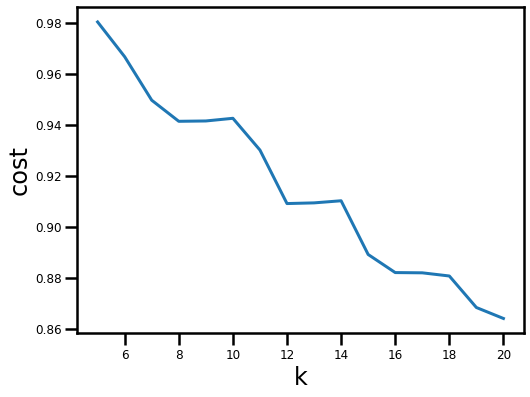

In [222]:
plot_k(x,silhouette_score) # Function call to visualize optimum number of k

In [225]:
predictions = kmeans_main(train_data, test_data, 5) # Function call for the main K-means model with k=5

--------------------------------------------------------------------------------
Silhouette with squared euclidean distance =  0.9776749645905891


In [226]:
# Recommend similar books 
def recommend_books(predictions, title):
    new_df = predictions.join(final_data.select("title","features"), on="features")
    new_df = new_df.select("title", "prediction")
    new_df = new_df.join(df.select("bookID","authors","title"), on="title")
    new_df = new_df.toPandas()

    title = clean_title(title) # Function call for fetch the complete title of the book

    index = new_df["prediction"][new_df["title"] ==title].iloc[0] # extracts the cluster number
    books = list(new_df["title"][new_df["prediction"] ==index]) # extracts the complete list of books in a particular cluster

    random.shuffle(books)
    for i in books:
        if title == i:
            books.remove(i)

    for i in range(5):
        print(books[i])

In [227]:
recommend_books(predictions, title="Harry Potter")

The Novice (Black Magician Trilogy  #2)
School's Out—Forever (Maximum Ride  #2)
Jane Eyre
The Histories
"A Wrinkle in Time: A Guide for Using ""A Wrinkle in Time"" in the Classroom"


In [112]:
recommend_books(predictions, title="The Lord of the Rings")

Death by Black Hole: And Other Cosmic Quandaries
Atlas Shrugged
Critique of Pure Reason
My Sister's Keeper
The Player's Handbook: The Ultimate Guide on Dating and Relationships


In [229]:
recommend_books(predictions, title="The Da Vinci Code")

Firefighters in the Dark
A Supposedly Fun Thing I'll Never Do Again: Essays and Arguments
Phylogenesis (Founding of the Commonwealth  #1)
Case Closed: Lee Harvey Oswald and the Assassination of JFK
All the King's Men


## K-Means

Recommends similar authors based on favourite book

In [233]:
from pyspark.sql.functions import col, round

# New dataframe with average (# of pages per book, text reviews, rating) per author
avg_df = df["authors",'average_rating',
       "num_pages","ratings_count","text_reviews_count"].groupBy("authors").avg().\
select("authors",round(col("avg(average_rating)"),2).alias("average_rating"),
       round(col("avg(num_pages)"),2).alias("avg_num_pages"),
       round(col("avg(ratings_count)"),2).alias("avg_ratings_count"),
       round(col("avg(text_reviews_count)"),2).alias("avg_text_reviews_count"))

In [234]:
avg_df = avg_df.join(df.select(["authors","bookID","title"]), on = "authors")

In [235]:
input_cols = ['average_rating','avg_num_pages','avg_ratings_count','avg_text_reviews_count']
output = create_assembler(avg_df, input_cols) # Function call to create vector assembler
final_data = output.select("features", 'authors',"title")
final_data.show()

+--------------------+--------------------+--------------------+
|            features|             authors|               title|
+--------------------+--------------------+--------------------+
|[4.23,360.64,4416...|       Douglas Adams|The More Than Com...|
|[4.23,360.64,4416...|       Douglas Adams|The Hitchhiker's ...|
|[4.23,360.64,4416...|       Douglas Adams|The Hitchhiker's ...|
|[4.23,360.64,4416...|       Douglas Adams|The Illustrated H...|
|[4.23,360.64,4416...|       Douglas Adams|The Hitchhiker's ...|
|[4.23,360.64,4416...|       Douglas Adams|So Long  and Than...|
|[4.23,360.64,4416...|       Douglas Adams|Life  the Univers...|
|[4.23,360.64,4416...|       Douglas Adams|Dirk Gently's Hol...|
|[4.23,360.64,4416...|       Douglas Adams|The Salmon of Dou...|
|[4.23,360.64,4416...|       Douglas Adams|The Long Dark Tea...|
|[4.23,360.64,4416...|       Douglas Adams|The Ultimate Hitc...|
|[4.23,360.64,4416...|       Douglas Adams|The Hitchhiker's ...|
|[4.23,360.64,4416...|   

In [237]:
scaled_data = scaling(final_data) # Function call to scale the data(Standard Scaler)
train_data, test_data = split(scaled_data) # Function call to split the data into train-test sets

7836 rows in the train_data
3287 rows in the test_data


In [238]:
x,silhouette_score = best_k(scaled_data) # Function call to find optimum number of k

Silhouette Score for k=5: 0.9402150672161864
Silhouette Score for k=6: 0.9197775885048334
Silhouette Score for k=7: 0.9172445677283927
Silhouette Score for k=8: 0.9213377648484787
Silhouette Score for k=9: 0.886154627261732
Silhouette Score for k=10: 0.8981844876975833
Silhouette Score for k=11: 0.8549365222475015
Silhouette Score for k=12: 0.8716734080054686
Silhouette Score for k=13: 0.8872413153635605
Silhouette Score for k=14: 0.8636136659088839
Silhouette Score for k=15: 0.8644655676416697
Silhouette Score for k=16: 0.8643317705741562
Silhouette Score for k=17: 0.8118671890270742
Silhouette Score for k=18: 0.8476145799796846


Silhouette Score for k=19: 0.8477140057762816
Silhouette Score for k=20: 0.848711638095052


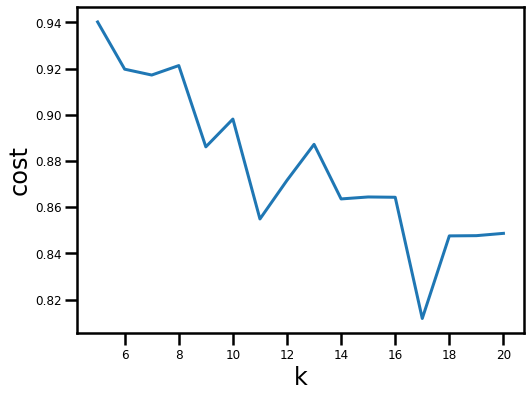

In [240]:
plot_k(x,silhouette_score) # Function call to visualize optimum number of k

In [241]:
# Creates the model, evalutes and gives the prediction
pred_author = kmeans_main(train_data, test_data, 5) # Function call for the main K-means model with k=5
pred_author.show()

--------------------------------------------------------------------------------
Silhouette with squared euclidean distance =  0.9626563915517907
+--------------------+--------------------+----------+
|            features|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|      (4,[1],[71.0])|(4,[1],[0.3415573...|         0|
|     (4,[1],[112.0])|(4,[1],[0.5387947...|         0|
|     (4,[1],[112.0])|(4,[1],[0.5387947...|         0|
|     (4,[1],[210.0])|(4,[1],[1.0102401...|         0|
|  [2.62,0.0,8.0,1.0]|[8.00328879955559...|         0|
| [2.75,24.0,4.0,1.0]|[8.40039854915186...|         0|
|[2.8,144.0,10.0,1.0]|[8.55313306822735...|         0|
|[2.83,139.0,2.0,1.0]|[8.64477377967265...|         0|
|[2.86,286.0,114.0...|[8.73641449111794...|         0|
| [3.1,800.4,1.0,0.0]|[9.46954018268028...|         0|
|[3.14,368.0,7.0,1.0]|[9.59172779794068...|         0|
|[3.15,354.0,242.0...|[9.62227470175577...|         0|
|[3.16,340.0,123.0...|[9.6528

In [242]:
# Recommends authors based on favorite book
def recommend_authors(predictions, title):
    new_df = pred_author.join(final_data.select("authors","title","features"), on="features")
    new_df = new_df.select("title", "authors","prediction")
    new_df = new_df.join(df.select("bookID","authors"), on="authors")
    new_df = new_df.toPandas()

    title = clean_title(title)

    index = new_df["prediction"][new_df["title"] ==title].iloc[0]
    authors = list(new_df["authors"][new_df["prediction"] ==index].unique())

    random.shuffle(authors)
    for i in range(5):
        print(authors[i])

In [243]:
recommend_authors(pred_author, title="Harry Potter")

Miguel de Cervantes Saavedra/Walter Starkie
Paulo Coelho/Clifford E. Landers
Jonathan Parshall/Anthony Tully
Nancy White Carlstrom/Bruce Degen
Jonathan Swift/Isaac Asimov


In [244]:
recommend_authors(pred_author, title="The Lord of the Rings")

J.R. Ward
Caleb Carr
John Steinbeck
John Grogan
Lois Lowry


In [245]:
recommend_authors(pred_author, title="The Da Vinci Code")

William Makepeace Thackeray/John Carey
Louis Sachar
Daniel Defoe/Virginia Woolf
Mitch Albom
Jhumpa Lahiri


## Alternating Least Squares (ALS)

Recommend books of the favorite author with book rating 4.0 and above

In [246]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [247]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="authors", outputCol="authors_ID") # Assigns each author a unique ID
indexed = indexer.fit(df).transform(df)

In [248]:
als_df = indexed.select('bookID','authors_ID','average_rating',"title","authors")
als_df.show()

+------+----------+--------------+--------------------+--------------------+
|bookID|authors_ID|average_rating|               title|             authors|
+------+----------+--------------+--------------------+--------------------+
|     1|     256.0|          4.57|Harry Potter and ...|J.K. Rowling/Mary...|
|     2|     256.0|          4.49|Harry Potter and ...|J.K. Rowling/Mary...|
|     4|      66.0|          4.42|Harry Potter and ...|        J.K. Rowling|
|     5|     256.0|          4.56|Harry Potter and ...|J.K. Rowling/Mary...|
|     8|     256.0|          4.78|Harry Potter Boxe...|J.K. Rowling/Mary...|
|     9|    6367.0|          3.74|"Unauthorized Har...|W. Frederick Zimm...|
|    10|      66.0|          4.73|Harry Potter Coll...|        J.K. Rowling|
|    12|      42.0|          4.38|The Ultimate Hitc...|       Douglas Adams|
|    13|      42.0|          4.38|The Ultimate Hitc...|       Douglas Adams|
|    14|      42.0|          4.22|The Hitchhiker's ...|       Douglas Adams|

In [249]:
# a). Creates the instance of the "Model" class
# b). Builds the ALS model by calling "als" function from the class "Model" 
# c). Calls "predict" function from the class "Model" 
# d). Returns the prediction and the model for futher analysis

def als_main(train_data, test_data):
    als_o = Model(train_data, test_data)
    model = als_o.als(10, "authors_ID", "bookID", "average_rating")
    
    predictions, evaluator = als_o.predict(model, "rmse", 
                                           "average_rating","prediction")

    rmse = evaluator.evaluate(predictions)

    print('-'*80)
    print("Root-mean-square error = " + str(rmse))
    
    return predictions, model

In [250]:
predictions, model = als_main(als_df, als_df) # Function call for the main als model

--------------------------------------------------------------------------------
Root-mean-square error = 0.003026753667328423


In [251]:
predictions.show()

+------+----------+--------------+--------------------+--------------------+----------+
|bookID|authors_ID|average_rating|               title|             authors|prediction|
+------+----------+--------------+--------------------+--------------------+----------+
|   280|    4573.0|          3.66|The Ravishing of ...|Marguerite Duras/...|  3.656766|
|   288|    3672.0|          4.21|Kahlil Gibran: Hi...|Jean Gibran/جبران...|  4.207178|
|   394|     186.0|          4.14|Lincoln at Gettys...|         Garry Wills| 4.1368117|
|   435|      38.0|          3.89|The Locked Room (...|         Paul Auster|  3.886876|
|   446|      38.0|          3.84|The Brooklyn Follies|         Paul Auster|  3.836916|
|   484|    4016.0|          4.39|Reinventing the E...|Joy Harjo/Gloria ...| 4.3872914|
|   664|     172.0|          3.87|    The Fountainhead|            Ayn Rand| 3.8666484|
|   667|     172.0|          3.63|              Anthem|            Ayn Rand| 3.6268568|
|   797|    4418.0|          4.0

In [252]:
# Recommend books from same author with average book rating 4.0 and above
def author_books(author, model, min_rating):
    single = als_df.filter(als_df['authors']==author).select(["authors","authors_ID","bookID","title"])
    reccomendations = model.transform(single)
    books_reccomendations = reccomendations.filter(reccomendations.prediction >= min_rating).\
    select("title").orderBy('prediction',ascending=False).toPandas()
    
    books = list(books_reccomendations["title"].unique())[0:5]
    if len(books) >= 5:
        for i in range(5):
            print(books[i])
    else:
        for i in range(len(books)):
            print(books[i])
    

In [253]:
author_books("Stephen King", model, 4.0)

Carrie / 'Salem's Lot / The Shining
The Green Mile
Different Seasons
On Writing: A Memoir
The Dark Tower (The Dark Tower #7)


In [254]:
author_books("Mark Twain", model, 4.0)

Mark Twain: Selected Works
The Wit and Wisdom of Mark Twain


In [255]:
author_books("J.R.R. Tolkien", model, 4.0)

J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings
The Lord of the Rings / The Hobbit
The Return of the King (The Lord of the Rings  #3)
The Lord of the Rings Millennium Edition Boxed Set (The Lord of the Rings  #1-3)
The Lord of the Rings (The Lord of the Rings  #1-3)


In [256]:
author_books("Dan Brown", model, 4.0)

In [257]:
author_books("Dan Brown", model, 3.5)

Angels & Demons (Robert Langdon  #1)
Ángeles y demonios (Robert Langdon  #1)
The Da Vinci Code (Robert Langdon  #2)
The Da Vinci Code
Deception Point


In [258]:
spark.stop()